In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import datasets, transforms as T

import random, os, pathlib, time
from tqdm import tqdm
# from sklearn import datasets

In [2]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

In [3]:
from tqdm import tqdm
import os, time, sys
import json

In [4]:
import dtnnlib as dtnn

In [5]:
mnist_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=[0.5,],
        std=[0.5,],
    ),
])

train_dataset = datasets.FashionMNIST(root="../../../../_Datasets/", train=True, download=True, transform=mnist_transform)
test_dataset = datasets.FashionMNIST(root="../../../../_Datasets/", train=False, download=True, transform=mnist_transform)

In [6]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

In [7]:
for xx, yy in train_loader:
    xx, yy = xx.to(device), yy.to(device)
    print(xx.shape, yy.shape)
    break

/home/tsuman/All_Files/Program_Files/miniconda/lib/python3.9/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


torch.Size([50, 1, 28, 28]) torch.Size([50])


In [506]:
model = nn.Sequential(
            dtnn.DistanceTransform_MinExp(784, 785),
#             nn.Linear(784, 785),
#                 nn.LayerNorm(785),
            nn.BatchNorm1d(785),
            nn.Linear(785, 200),
            nn.BatchNorm1d(200),
            nn.LeakyReLU(),
            nn.Linear(200, 50),
            nn.BatchNorm1d(50),
            nn.LeakyReLU(),
            nn.Linear(50, 10))

In [507]:
model.to(device)

Sequential(
  (0): DistanceTransform_MinExp()
  (1): BatchNorm1d(785, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=785, out_features=200, bias=True)
  (3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Linear(in_features=200, out_features=50, bias=True)
  (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=50, out_features=10, bias=True)
)

In [508]:
# model[0].set_centroid_to_data_maxdist(train_loader)
# model[0].set_centroid_to_data(train_loader)
# model[0].set_centroid_to_data_randomly(train_loader)

In [509]:
# dt = dtnn.DistanceTransform(784, 785)
# dt.set_centroid_to_data_randomly(train_loader)
# model[0].weight.data = dt.centers.data.to(device)

In [510]:
# model.to(device)

In [511]:
# train_loader

In [512]:
## Following is copied from 
### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

# Training
def train(epoch, model, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device).view(-1, 28*28), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    return

In [513]:
best_acc = -1
def test(epoch, model, model_name):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device).view(-1, 28*28), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f'./models/{model_name}.pth')
        best_acc = acc

In [514]:
learning_rate = 0.0001
EPOCHS = 50

In [515]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = nn.CrossEntropyLoss()

In [516]:
model_name = f"01.1_viz_act_fmnist_v0_dist_minexp"
        
best_acc = -1
for epoch in range(EPOCHS):
    train(epoch, model, optimizer)
    test(epoch, model, model_name)
    scheduler.step()
print(best_acc)

100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 132.17it/s]


[Train] 0 Loss: 0.820 | Acc: 79.687 47812/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 139.63it/s]


[Test] 0 Loss: 0.520 | Acc: 84.380 8438/10000
Saving..


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 132.68it/s]


[Train] 1 Loss: 0.439 | Acc: 86.162 51697/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 142.34it/s]


[Test] 1 Loss: 0.422 | Acc: 85.830 8583/10000
Saving..


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 132.06it/s]


[Train] 2 Loss: 0.356 | Acc: 87.920 52752/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 138.60it/s]


[Test] 2 Loss: 0.374 | Acc: 86.790 8679/10000
Saving..


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 131.88it/s]


[Train] 3 Loss: 0.312 | Acc: 89.138 53483/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 137.16it/s]


[Test] 3 Loss: 0.355 | Acc: 87.390 8739/10000
Saving..


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 132.15it/s]


[Train] 4 Loss: 0.285 | Acc: 89.802 53881/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 138.63it/s]


[Test] 4 Loss: 0.347 | Acc: 87.700 8770/10000
Saving..


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 132.37it/s]


[Train] 5 Loss: 0.260 | Acc: 90.740 54444/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 138.01it/s]


[Test] 5 Loss: 0.344 | Acc: 87.810 8781/10000
Saving..


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 131.26it/s]


[Train] 6 Loss: 0.238 | Acc: 91.582 54949/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 175.91it/s]


[Test] 6 Loss: 0.342 | Acc: 88.090 8809/10000
Saving..


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 132.64it/s]


[Train] 7 Loss: 0.222 | Acc: 92.182 55309/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 139.14it/s]


[Test] 7 Loss: 0.335 | Acc: 88.390 8839/10000
Saving..


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 131.98it/s]


[Train] 8 Loss: 0.204 | Acc: 92.788 55673/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 139.01it/s]


[Test] 8 Loss: 0.338 | Acc: 88.640 8864/10000
Saving..


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 132.10it/s]


[Train] 9 Loss: 0.191 | Acc: 93.240 55944/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 139.17it/s]


[Test] 9 Loss: 0.343 | Acc: 88.650 8865/10000
Saving..


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 131.09it/s]


[Train] 10 Loss: 0.176 | Acc: 93.777 56266/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 138.24it/s]


[Test] 10 Loss: 0.344 | Acc: 88.690 8869/10000
Saving..


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 132.27it/s]


[Train] 11 Loss: 0.165 | Acc: 94.108 56465/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 139.05it/s]


[Test] 11 Loss: 0.353 | Acc: 88.320 8832/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 132.79it/s]


[Train] 12 Loss: 0.153 | Acc: 94.645 56787/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 138.36it/s]


[Test] 12 Loss: 0.351 | Acc: 88.590 8859/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 131.63it/s]


[Train] 13 Loss: 0.142 | Acc: 95.125 57075/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 141.47it/s]


[Test] 13 Loss: 0.362 | Acc: 88.520 8852/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:08<00:00, 134.58it/s]


[Train] 14 Loss: 0.133 | Acc: 95.427 57256/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 173.81it/s]


[Test] 14 Loss: 0.364 | Acc: 88.760 8876/10000
Saving..


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 131.63it/s]


[Train] 15 Loss: 0.123 | Acc: 95.680 57408/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 138.78it/s]


[Test] 15 Loss: 0.379 | Acc: 88.490 8849/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 131.98it/s]


[Train] 16 Loss: 0.113 | Acc: 96.150 57690/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 136.97it/s]


[Test] 16 Loss: 0.380 | Acc: 88.510 8851/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 132.94it/s]


[Train] 17 Loss: 0.104 | Acc: 96.420 57852/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 134.54it/s]


[Test] 17 Loss: 0.393 | Acc: 88.670 8867/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 131.60it/s]


[Train] 18 Loss: 0.099 | Acc: 96.658 57995/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 137.83it/s]


[Test] 18 Loss: 0.400 | Acc: 88.740 8874/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 131.21it/s]


[Train] 19 Loss: 0.089 | Acc: 97.023 58214/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 141.73it/s]


[Test] 19 Loss: 0.405 | Acc: 88.620 8862/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 132.42it/s]


[Train] 20 Loss: 0.084 | Acc: 97.182 58309/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 136.98it/s]


[Test] 20 Loss: 0.412 | Acc: 88.780 8878/10000
Saving..


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 130.19it/s]


[Train] 21 Loss: 0.078 | Acc: 97.450 58470/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 138.82it/s]


[Test] 21 Loss: 0.425 | Acc: 88.430 8843/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 130.63it/s]


[Train] 22 Loss: 0.070 | Acc: 97.733 58640/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 137.00it/s]


[Test] 22 Loss: 0.418 | Acc: 88.790 8879/10000
Saving..


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 131.43it/s]


[Train] 23 Loss: 0.067 | Acc: 97.863 58718/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 137.10it/s]


[Test] 23 Loss: 0.432 | Acc: 88.570 8857/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 132.18it/s]


[Train] 24 Loss: 0.062 | Acc: 98.010 58806/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 138.48it/s]


[Test] 24 Loss: 0.444 | Acc: 88.700 8870/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 131.70it/s]


[Train] 25 Loss: 0.058 | Acc: 98.160 58896/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 137.89it/s]


[Test] 25 Loss: 0.453 | Acc: 88.580 8858/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 131.82it/s]


[Train] 26 Loss: 0.053 | Acc: 98.377 59026/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 138.69it/s]


[Test] 26 Loss: 0.464 | Acc: 88.540 8854/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 131.35it/s]


[Train] 27 Loss: 0.049 | Acc: 98.517 59110/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 136.25it/s]


[Test] 27 Loss: 0.466 | Acc: 88.430 8843/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 131.80it/s]


[Train] 28 Loss: 0.046 | Acc: 98.620 59172/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 137.35it/s]


[Test] 28 Loss: 0.471 | Acc: 88.470 8847/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 133.13it/s]


[Train] 29 Loss: 0.044 | Acc: 98.718 59231/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 135.62it/s]


[Test] 29 Loss: 0.471 | Acc: 88.700 8870/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 132.28it/s]


[Train] 30 Loss: 0.040 | Acc: 98.805 59283/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 141.85it/s]


[Test] 30 Loss: 0.483 | Acc: 88.540 8854/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 129.90it/s]


[Train] 31 Loss: 0.037 | Acc: 98.945 59367/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 135.43it/s]


[Test] 31 Loss: 0.503 | Acc: 88.550 8855/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 131.41it/s]


[Train] 32 Loss: 0.035 | Acc: 99.023 59414/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 137.73it/s]


[Test] 32 Loss: 0.490 | Acc: 88.650 8865/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 129.41it/s]


[Train] 33 Loss: 0.034 | Acc: 99.107 59464/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 139.19it/s]


[Test] 33 Loss: 0.492 | Acc: 88.420 8842/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 132.56it/s]


[Train] 34 Loss: 0.030 | Acc: 99.257 59554/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 138.51it/s]


[Test] 34 Loss: 0.510 | Acc: 88.520 8852/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 131.77it/s]


[Train] 35 Loss: 0.030 | Acc: 99.180 59508/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 140.46it/s]


[Test] 35 Loss: 0.503 | Acc: 88.600 8860/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 132.27it/s]


[Train] 36 Loss: 0.027 | Acc: 99.303 59582/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 137.04it/s]


[Test] 36 Loss: 0.502 | Acc: 88.680 8868/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 132.25it/s]


[Train] 37 Loss: 0.026 | Acc: 99.325 59595/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 143.57it/s]


[Test] 37 Loss: 0.516 | Acc: 88.560 8856/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 131.44it/s]


[Train] 38 Loss: 0.025 | Acc: 99.392 59635/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 136.54it/s]


[Test] 38 Loss: 0.510 | Acc: 88.530 8853/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 130.10it/s]


[Train] 39 Loss: 0.024 | Acc: 99.427 59656/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 137.28it/s]


[Test] 39 Loss: 0.516 | Acc: 88.620 8862/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 131.55it/s]


[Train] 40 Loss: 0.023 | Acc: 99.470 59682/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 136.64it/s]


[Test] 40 Loss: 0.525 | Acc: 88.720 8872/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 130.69it/s]


[Train] 41 Loss: 0.022 | Acc: 99.482 59689/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 140.11it/s]


[Test] 41 Loss: 0.526 | Acc: 88.480 8848/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 132.59it/s]


[Train] 42 Loss: 0.021 | Acc: 99.567 59740/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 135.72it/s]


[Test] 42 Loss: 0.517 | Acc: 88.670 8867/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 129.63it/s]


[Train] 43 Loss: 0.021 | Acc: 99.515 59709/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 136.94it/s]


[Test] 43 Loss: 0.519 | Acc: 88.720 8872/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 131.50it/s]


[Train] 44 Loss: 0.020 | Acc: 99.555 59733/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 138.30it/s]


[Test] 44 Loss: 0.522 | Acc: 88.710 8871/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 133.26it/s]


[Train] 45 Loss: 0.020 | Acc: 99.563 59738/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 139.54it/s]


[Test] 45 Loss: 0.523 | Acc: 88.790 8879/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 132.31it/s]


[Train] 46 Loss: 0.019 | Acc: 99.600 59760/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 138.22it/s]


[Test] 46 Loss: 0.522 | Acc: 88.770 8877/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 131.58it/s]


[Train] 47 Loss: 0.019 | Acc: 99.643 59786/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 139.11it/s]


[Test] 47 Loss: 0.520 | Acc: 88.670 8867/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 131.98it/s]


[Train] 48 Loss: 0.019 | Acc: 99.617 59770/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 137.08it/s]


[Test] 48 Loss: 0.523 | Acc: 88.700 8870/10000


100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 132.96it/s]


[Train] 49 Loss: 0.019 | Acc: 99.613 59768/60000


100%|██████████████████████████████████████████████████| 200/200 [00:01<00:00, 140.68it/s]

[Test] 49 Loss: 0.523 | Acc: 88.560 8856/10000
88.79


In [489]:
model.zero_grad()

In [490]:
checkpoint = torch.load(f'./models/{model_name}.pth')
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

best_acc, start_epoch

(89.47, 42)

In [491]:
## Linear(90.02, 28)
## Distance

In [492]:
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [493]:
## Viz

In [494]:
model.eval()
for xx, yy in train_loader:
    dists = model[0](xx.reshape(-1, 784).to(device))
    yout = model[1:](dists)
    break
# model.train()
dists.shape

torch.Size([50, 785])

(array([5.0000e+00, 1.2100e+02, 2.5660e+03, 1.2792e+04, 1.6952e+04,
        6.0890e+03, 6.7400e+02, 3.2000e+01, 1.4000e+01, 5.0000e+00]),
 array([-5.0443454 , -3.850804  , -2.6572626 , -1.4637213 , -0.27017984,
         0.92336154,  2.1169028 ,  3.3104444 ,  4.503986  ,  5.697527  ,
         6.8910685 ], dtype=float32),
 <BarContainer object of 10 artists>)

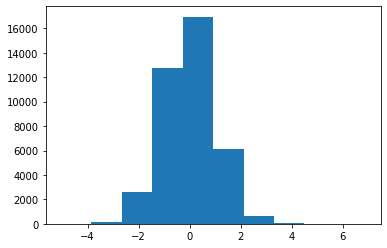

In [495]:
plt.hist(dists.data.cpu().numpy().reshape(-1))

In [496]:
dists.max()

tensor(6.8911, device='cuda:0', grad_fn=<MaxBackward1>)

In [497]:
out = yout.data.argmax(dim=-1).cpu()
out.shape

torch.Size([50])

## UMAP - from library

In [498]:
import umap

In [499]:
embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1)
# embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1,
# #                   target_metric='euclidean',
#                   target_metric='categorical',
#                   target_weight=0.1
#                  )

In [500]:
cent = model[0].centers.data
# cent = model[0].weight.data

center_lbl = model(cent)
output_cent = torch.softmax(center_lbl, dim=1).argmax(dim=1).data.cpu().numpy()
# output_cent = center_lbl.data.cpu().numpy()

torch.unique(torch.softmax(center_lbl, dim=1).argmax(dim=1), return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0'),
 tensor([ 46,  16,  17,  30,  13, 200,  38,   8, 417], device='cuda:0'))

In [501]:
# model[0].weight.data.shape
# model[0].centers.data.shape

In [502]:
centers = cent.cpu().numpy()

embedding = embed.fit_transform(centers)
# embedding = embed.fit_transform(centers, output_cent)

In [503]:
xtransf = embed.transform(xx.numpy().reshape(-1, 784))

In [504]:
i = 0

0/50


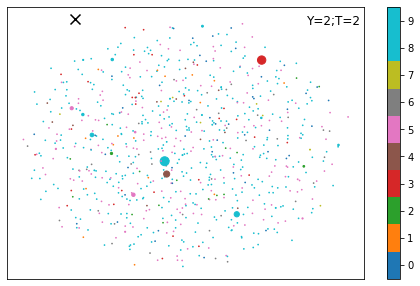

1/50


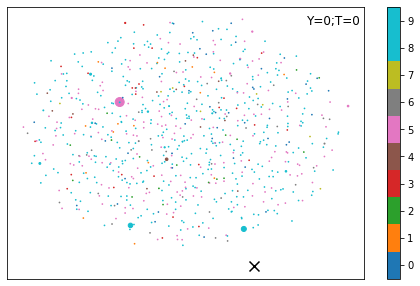

2/50


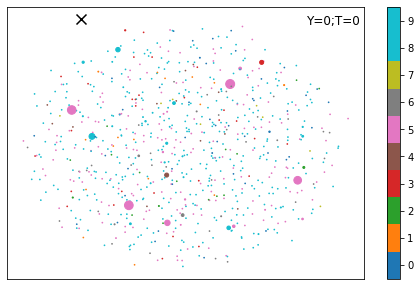

3/50


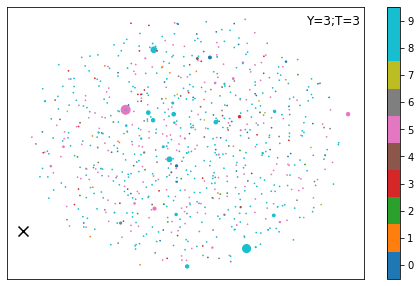

4/50


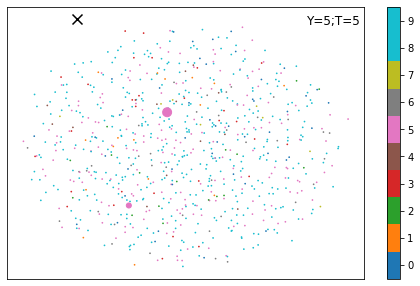

5/50


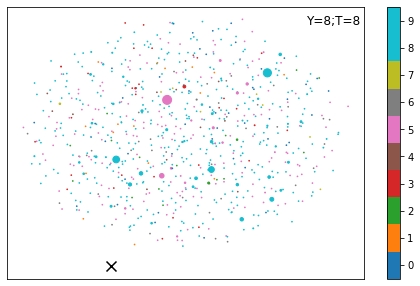

6/50


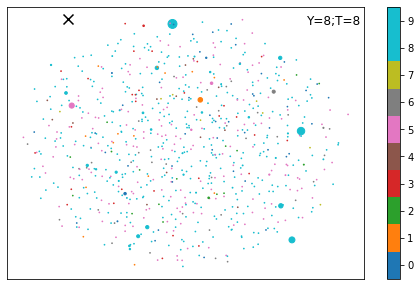

7/50


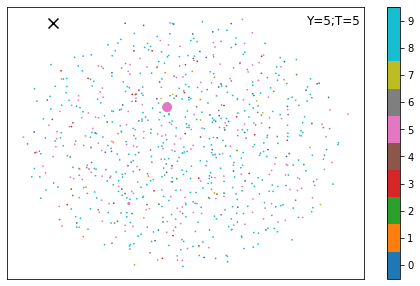

8/50


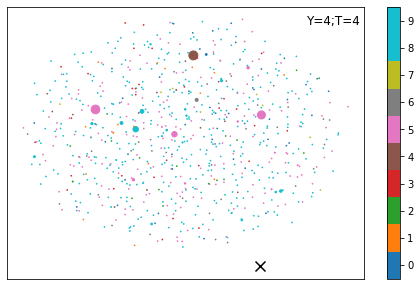

9/50


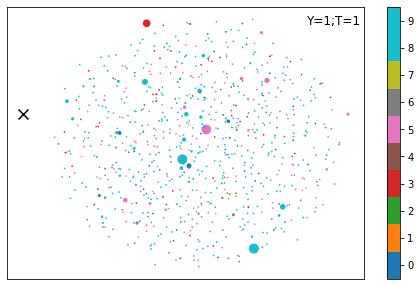

10/50


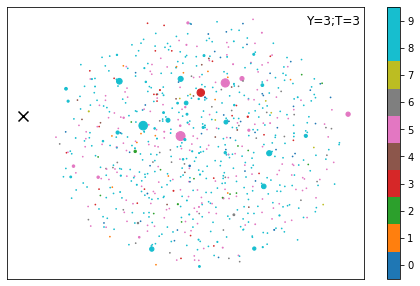

11/50


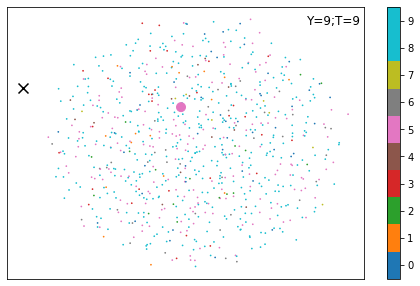

12/50


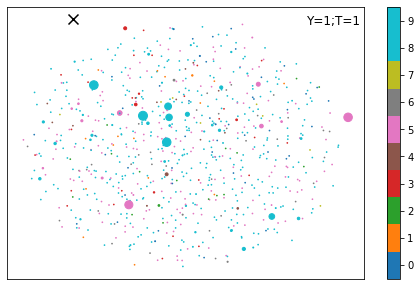

13/50


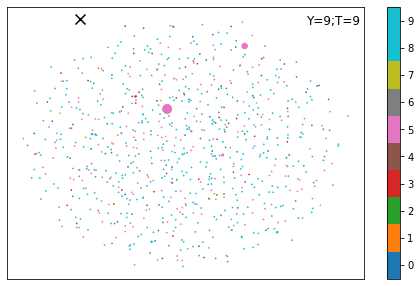

14/50


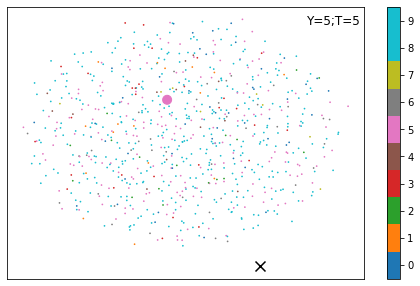

15/50


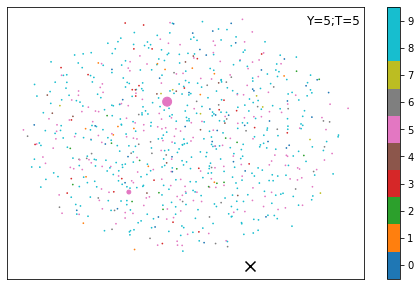

16/50


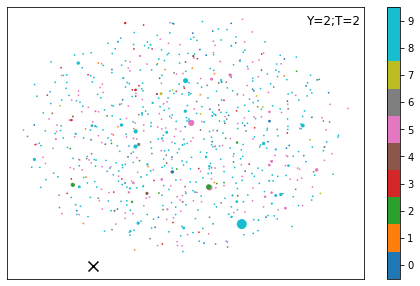

17/50


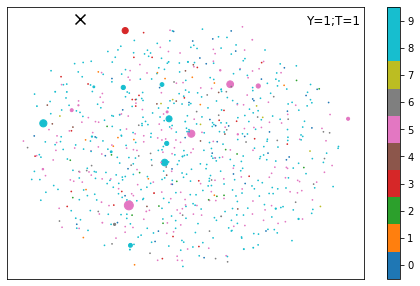

18/50


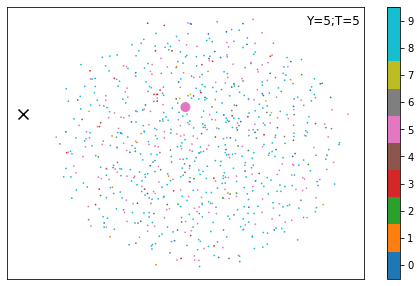

19/50


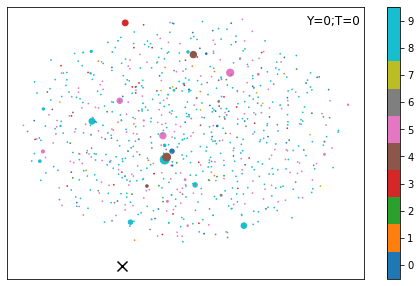

In [505]:
for i in range(20):
    activ = dists.data.cpu().numpy()[i]

    activ = -activ
    activ = activ - activ.min()
    activ = np.exp(-activ*3) #*0.05 for linear

    print(f"{i}/{len(dists)}")
    fig = plt.figure(figsize=(8,5))
    plt.scatter(xtransf[i,0], xtransf[i,1], marker='x', color='k', s=100)

    plt.text(.84, .97, f'Y={int(out[i])};T={int(yy[i])}', ha='left', va='top', transform=fig.axes[0].transAxes, fontsize="large")

    plt.scatter(embedding[:,0], embedding[:, 1], c=output_cent, s=np.maximum(activ*80, 0.5), cmap="tab10")
#     plt.scatter(embedding[:,0], embedding[:, 1], c=output_cent, s=np.maximum(activ*80, 0.0), cmap="tab10")

    plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)

    cbar = plt.colorbar(ticks=range(10), #label='classes', 
                        boundaries=np.arange(11)-0.5)
    cbar.set_ticks(np.arange(10))
    cbar.set_ticklabels(list(range(10)))

#     plt.savefig(f"./outputs/01.1_fmnist_viz/dist_viz_{i}.pdf", bbox_inches='tight')
    plt.show()
# print("Label",int(yy[i]))
# i += 1

In [461]:
model

Sequential(
  (0): DistanceTransform()
  (1): BatchNorm1d(785, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=785, out_features=200, bias=True)
  (3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Linear(in_features=200, out_features=50, bias=True)
  (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=50, out_features=10, bias=True)
)

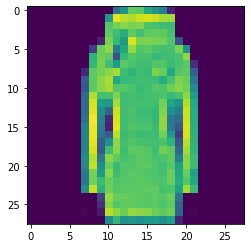

In [204]:
plt.imshow(xx.cpu()[i].reshape(28,28))

In [259]:
# !mkdir ./outputs/01.1_fmnist_viz/

In [75]:
# xtransf = embed.transform(xx.numpy().reshape(-1, 784))

In [76]:
# xtransf

array([[ 5.327273  ,  3.4802163 ],
       [ 8.103108  ,  1.1775126 ],
       [ 4.231838  ,  2.1473553 ],
       [ 6.188856  , -2.3980184 ],
       [ 5.927128  , -0.28537673],
       [ 8.380998  ,  1.513808  ],
       [ 4.8245444 ,  3.8099842 ],
       [ 1.5484097 , -1.4111968 ],
       [ 5.387061  ,  3.5476792 ],
       [ 7.154016  , -0.3103984 ],
       [ 5.5871053 , -1.8317536 ],
       [-0.593835  , -4.2884808 ],
       [ 4.082549  ,  2.566467  ],
       [ 4.114878  ,  2.6835155 ],
       [ 5.877249  , -1.8982512 ],
       [ 4.553458  ,  3.9061067 ],
       [ 0.09760088, -1.5419202 ],
       [ 6.969405  , -2.3927028 ],
       [ 3.1905725 ,  0.7234355 ],
       [ 1.0709033 ,  1.2103614 ],
       [-0.32115656, -4.5230722 ],
       [ 1.1580366 , -3.4607623 ],
       [ 5.4307914 ,  3.55691   ],
       [ 4.631719  , -0.26810896],
       [-0.63336325, -3.4890924 ],
       [ 3.8880608 , -0.99367815],
       [ 0.596032  , -4.27747   ],
       [ 7.256253  ,  1.1596013 ],
       [ 4.3529124 ,